# Unpack Hub Clustering
#### Developed by Job de Vogel, Lisa-Marie Mueller and Jirri van den Bos

This project was developed for the course AR3B012 CORE, TU Delft. The goal of the 'Unpack' module is solving a Facility Location Problem, specifically finding the ideal number of hubs placed in a city, with their locations, considering all inhabitants of the city, based on user prefered weights.

The project has been tested on the Windows operating system. We do not guarantee this code working on other types of operating systems.

Altough thoroughly tested, we do not recommend using this project in commercial context. It has been developed for educational purposes only.

To be able to run this code efficiently, we recommend the following hardware:
- 16 GB or RAM;
- 6 core CPU (more is better);
- Good internet connection for data retrieval.

In [1]:
# Import the package developed by UNPACK
import unpack
import random

In [2]:
## Initialize variables
name = 'Delft_center_walk'
data_folder = 'data/'
vehicle_type = 'walk' # walk, bike, drive, all (See osmnx documentation)
coordinates = [52.018347, 52.005217, 4.369142, 4.350504]
#coordinates =  [52.03, 51.96, 4.4, 4.3] # Full Delft

## GENERATE NETWORK
Generate a new network using the functions in the CityNetwork class. If a network already has been generated and stored in the data folder, 
please continue with 'Prepare Network'!

In [3]:
# Initialize CityNetwork object [N, S, E, W]
City = unpack.CityNetwork(name, coordinates, vehicle_type)

In [4]:
# Load osm from local or online file
# If sever does not respond, please try again in 30 seconds
City.load_osm_graph(data_folder + name + '.osm')
City.load_building_addr(data_folder + 'runtime/' + name + '_building_addresses.csv', 
    data_folder + 'runtime/' + name + '_buildings.csv', 
    data_folder + 'runtime/' + name + '_addresses.csv',
    data_folder +'runtime/'+ name + '_cbs.xml')

print('Loading finished.')

Loading street network...
Finished loading
Loading buildings...
Finished adding EPSG:3857 coordinates
Assigning buildings to CBS buurt
Checking if a building is inside a buurt
14205 / 14205
Adding the CBS data to the dataframe
14205 / 14205
Loading finished.


In [5]:
# Add speeds, lengths and distances to graph
# Overwrite speed by using overwrite_bike=16
# Further types available: overwrite_walk and overwrite_epv
City.add_rel_attributes(overwrite_bike=16, overwrite_walk=5)

In [6]:
# Project graph to the correct coordinate system
City.project_graph()

In [7]:
# (Optional) assign an 'experience' weight to the graph
# Experience can be added based on street names
latitude = 52.005831
longitude = 4.371026

City.add_street_experience(['Oude Delft'], [10])

In [8]:
# Calculate dataframes of nodes and edges
City.convert_graph_edges_to_df()
City.convert_graph_nodes_to_df()

In [9]:
# Extract the destinations
destinations = City.get_yx_destinations()

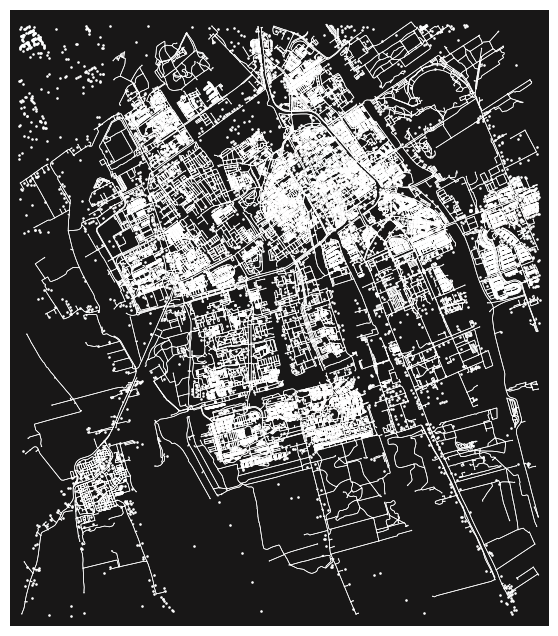

(<Figure size 800x800 with 1 Axes>, <AxesSubplot:>)

In [10]:
# (Optional) Plot the network
City.plot(destinations=destinations, show=True, save=True)

In [ ]:
# (Optional) Save Pickle file of CityNetwork object
City.save_graph(name, data_folder)

## Prepare Network
Load the CityNetwork object if it already has been initialized in a .pkl file.

In [ ]:
# Load the CityNetwork
City = unpack.CityNetwork.load_graph(name, data_folder)

## Compute Nearest Edges
To be able to compute shortest paths and clusters in the network, the nearest edges in the graph for each house have to be known. Therefore a multicore nearest edge algorithm has been developed.

Computing nearest edges may have a considerable computation time. Therefore it is recommended to run the computation once, and save the class object as a .pkl file again afterwards.

Approximate computation times:
* Full Delft: 15 minutes
* Delft city center: 30 seconds

In [ ]:
# Compute nearest edges
# ! Run only once !
cpus = None # Indicate number of cores in your device, None for max available

City.ne = None
City.nearest_edges(5, cpus=cpus)
City.save_graph(name, data_folder)

In [ ]:
# Remove houses further than x meters from edges
City.drop_outliers(30)
dest_edges = City.ne

# Extract new yx destinations
destinations = City.get_yx_destinations()

## Compute shortest paths
For this project, a multicore single source Dijkstra algorithm has been implemented to find the shortest paths between hubs and the closest houses. The code is adapted from OSMnx (Gboeing) and Taxicab (Nathan Rooy) but adds several functionalities. For more information, please check the code in multicore_shortest_path.

In [ ]:
# Calculate shortest paths by hub
# Check the code for description of inputs.
# For smaller networks, single core can be 2x faster than multicore.
num_hubs = 3
random.seed(2)
hubs = [(random.randint(6801030, 6803490), random.randint(484261, 486397)) for _ in range(num_hubs)]
# hubs = [(6801181, 486566)] # Architecture faculty

# Note: the status bar in output viewer indicates when a set of origins
# is sent to the cpu, not when it is finished.
paths = unpack.multicore_single_source_shortest_path(City.graph, hubs, destinations, dest_edges,
    skip_non_shortest=True, 
    skip_treshold=60,
    weight='travel_time', 
    cutoff=None, 
    cpus=3
    )

In [ ]:
# Convert results to DataFrame
colors = ['red', 'blue', 'green']
paths_df = unpack.paths_to_dataframe(paths, colors, hubs=hubs)
print(paths_df)

## Multiplot
Computing many plots with large networks can be computationally expensive. The multiplot package has been developed by Unpack to be able to plot and save many images using multiple cores.

Note: this functions is mostly memory bound. Make sure you are using a device with enough memory if you are using many cores.

In [ ]:
# For this example, the result of the shortest path computation is repeated for each core.
cpus = 1
colors = ['red', 'blue', 'green']

# Give a name, to avoid overwriting your plots
session_name = input("Please insert a name for this multiplot session: ")

# Extract the data from the saved DataFrame
# This is just for a one time example, in the actual algorithm, these values are extracted internally.
cluster_iterations = [list(paths_df.loc[:, 'Path'])] * cpus
session_name_mask = [f'{session_name}_0test_{i}' for i in range(cpus)]
color_masks = [list(paths_df.loc[:, 'Color_mask'])] * cpus
origins = [hubs] * cpus

unpack.multiplot_save(City, cluster_iterations, origins, destinations, session_name_mask, color_masks, colors, dpi=300, cpus=10, show=False)
print(f"Images saved to {data_folder + 'plot_pngs/' + session_name}")

## Clustering
Compute the clusters using Adaptive Weighted K-means clustering. Our implementation of k-means uses k++ for initialization, but is able to adapt k based on the following fitness values.

- Maximum weight: check if any hub has a weight (travel time) that is greater than the maximum (2.5 minutes walking).

OR:

- Long travel time: check how many people have a weight (travel time) that is greater than the maximum (2.5 minutes), determine if this is more than 10% of the total people served.

AND:

- Capacity: check if the number of people served is less than the maximum capacity of a hub.
- Unassigned: check if the number of people not assigned to a hub is more than 10% of the total people served.

In [ ]:
# Specify a name for this clustering process
cluster_name = input('Please input a unique clustering name: ')

# Initiate the cluster class in an object
clusters = unpack.NetworkClustering(cluster_name)

# Reset the internal hub data if object contains data
clusters.reset_hub_df(City)

In [ ]:
# (Optional) If clustering crashed, load the latest iteration
continue_clustering = False

if continue_clustering:
    # Specify the cluster_name
    path = input("Please insert the file name that you would like to load to continue clustering: ")
    
    # Continue clustering
    clusters.continue_clustering(path)
    print('Starting with iteration ', clusters.iteration)

In [ ]:
# Clustering settings
# Number of starting hubs
start_pt_ct = 3

# The number of new hubs to add when the fitness is not reached
point_count = 1

# Maximum CPU cores, use None for max available 
max_cpu_count = None

# Shortest path settings
skip_non_shortest=True
skip_treshold=60
weight='travel_time'
cutoff=1000

# Max travel time for users to hub in seconds
max_travel_time = 150

# Randome init seed
random.seed(12345)

# Colors used for the plots
hub_colors = ['red', 'tomato', 'orangered', 'lightsalmon', 'indianred', 'firebrick', 'gold', 'darkorange', 'yellow', 'yellowgreen', 'greenyellow', 'darkolivegreen', 'lawngreen', 'forestgreen', 'limegreen', 'darkgreen', 'green', 'seagreen', 'darkslategray', 'blue', 'deepskyblue', 'steelblue', 'dodgerblue', 'skyblue', 'cornflowerblue', 'royalblue', 'slateblue', 'darkslateblue', 'mediumslateblue', 'mediumpurple', 'rebeccapurple', 'blueviolet', 'darkviolet', 'mediumorchid' 'purple', 'darkmagenta', 'mediumvioletred', 'deeppink', 'palevioletred', 'crimson']

# For more settings, please look at internal kwargs of clustering.optimize_locations

In [ ]:
# Load boundary coordinates in right format for clustering
boundary_coordinates = City.format_boundary_coordinates()

In [ ]:
# Give a name, to avoid overwriting your plots
session_name = cluster_name

In [ ]:
# Optimize the locations of the hubs using Adaptive Weighted K-means Clustering
clusters.optimize_locations(City, session_name, data_folder, boundary_coordinates, destinations, weight, cutoff, skip_non_shortest, skip_treshold, start_pt_ct, point_count, max_travel_time, max_cpu_count, hub_colors, 
    max_people_served=2190, max_additional_clusters=3, max_iterations=3)

# For more settings, please look at internal kwargs of clustering.optimize_locations

In [ ]:
# Load the cluster iterations, file name, hubs and color_masks
dataframes_path = data_folder + session_name + '/Dataframe/'
cluster_iterations, file_names, hubs, route_color_masks, dest_color_masks, dataframes = clusters.load_dataframe(dataframes_path, session_name)
print(hubs)

In [ ]:
# Use multiplot to generate images
unpack.multiplot_save(City, cluster_iterations, hubs, destinations, file_names, route_color_masks, hub_colors, dest_color_masks=dest_color_masks, cpus=None)

In [ ]:
print(42)

## Future Improvements
The following improvements are suggested to improve the performance and general usage of this program:

### Fundamental problems
- Experience based shortest paths are not working ideally. The current method increases weight values of all network edges, except for the ones that should have a good experience value. This was implemented this way, because negative values cause negative weight cycles in the graph. A problem specific implementation of Dijkstra or Bellman-Ford would be me required to make this work effectively.

### Clustering
- new hubs based on capacity
- move hubs based on shortest paths
- solution for hubs with small number of people

### Speed and efficiency
The speed and efficiency can be increased with the following future methods:
- Nearest edge computations may be faster when memory is shared;
- It has been suggested that shortest path computation can further optimized by adding certain shortcuts to the network. By first analysing the network and indicating the most important edges (bottlenecks) one could pre-compute the shortest paths to these edges. This way, the Dijkstra algorithm can skip certain regions of the network. However, since we are using a single source version of Dijkstra, one has to compare the final speeds to see if shortcuts actually help improving the speed;
- One could analyse the network and remove 'dead ends'. In the current state, single source Dijkstra takes these dead ends in consideration, although they mostly do not contribute to the best route. Further research is required before implementation;
- Make sure the most centered hub in the network is computed on the first CPU core. This core will start first. It is expected that the most centered hub will take longest to compute, since the other hub computations are shortened by the shared memory paths data.
- Run this code through pypy and compare speeds to Python 3;
- It has been suggested that other Python packages than NetworkX are more efficient, since they are based on CPython or RPython. For general usage in the Architecture field, we do not recommend changing the code to c++ for speed.

### Pypi release
Before publishing this code to Pypi, it is recommended to take the following steps:
- Execute unittests;
- Code has only been tested on Windows Operating System. Other systems need to be checked.
- Simplify certain functions such as multiplot and shortest_path for general usage;
- This project is focused on a specific problem of placing hubs. Some functions and methods can be better generalized for future usage;
- The connection to Overpass servers is not ideal for larger networks, measurements have to be taken before publishing.
